In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates

from scipy.signal import argrelextrema
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

In [2]:
data_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmed_fn = "time_series_covid19_confirmed_global.csv"
deaths_fn = "time_series_covid19_deaths_global.csv"
recovered_fn = "time_series_covid19_recovered_global.csv"

In [3]:
#get files with data
import requests

def get_raw_from_git(link, filename, verbose=True):
    r = requests.get(link + filename)
    if verbose:
        if (r.status_code == requests.codes.ok):
            print(filename + " done")
        else:
            print(filename + " failed to get raw")
            return
    open(filename , 'wb').write(r.content)
    

get_raw_from_git(data_link, confirmed_fn)
get_raw_from_git(data_link, deaths_fn)
get_raw_from_git(data_link, recovered_fn)

#or just clone from here: https://github.com/CSSEGISandData/COVID-19

time_series_covid19_confirmed_global.csv done
time_series_covid19_deaths_global.csv done
time_series_covid19_recovered_global.csv done


### Notes

lists:
* confirmed - cumulative total confirmed cases
* deaths - cumulative deaths
* recovered - cumulative recovered


* d_infected - dI/dt, new daily confirmed cases
* d_recovered - dR/dt, new daily recovered
* removed = recovered + deaths
* Infected = confirmed - recovered

Constants:
* Nation - size of population
* removal_rate - γ
* infication_rate - β
***
<img src="SIR_reminder.svg" align="left" title="SIR_reminder"/>

In [4]:
#get lists with data from files
def get_data_list(filename, country="Ukraine"):
    df = pd.read_csv(filename, header = 0)
    dates = [datetime.datetime.strptime(i, "%m/%d/%y") for i in df.columns[4:]]
    datalist = df.loc[df['Country/Region'] == country].values.tolist()[0][4:]
    datalist = np.array(datalist, dtype=np.float64)
    return(datalist, dates)
    
confirmed, dates = get_data_list(confirmed_fn)   
deaths = get_data_list(deaths_fn)[0]
recovered = get_data_list(recovered_fn)[0]

#skip first N days where there were no cases
days_to_skip = len([i for i in confirmed if i<2])
print("days_to_skip =", days_to_skip)

dates = dates[days_to_skip:]
confirmed = confirmed[days_to_skip:]
deaths = deaths[days_to_skip:]
recovered = recovered[days_to_skip:]

#creating lists for SIR model
removed = recovered + deaths
infected = confirmed - removed

d_confirmed = np.diff(confirmed, prepend=confirmed[0])
d_infected = np.diff(infected, prepend=infected[0])
d_removed = np.diff(removed, prepend=removed[0])

days_to_skip = 51


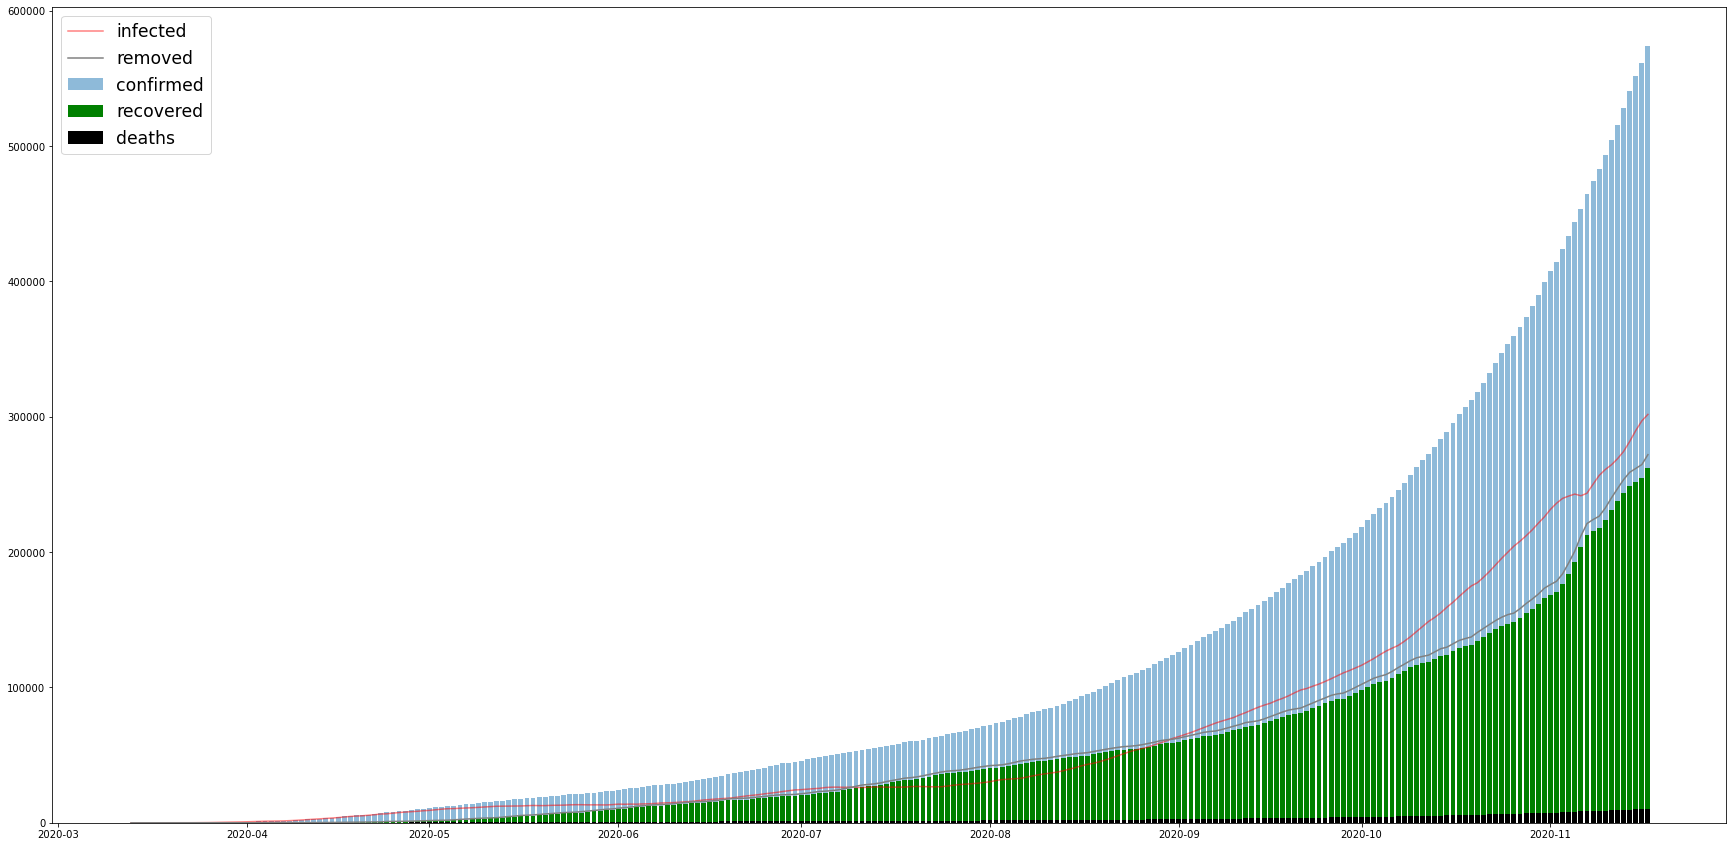

In [5]:
#visual check of imported data

plt.rcParams["figure.figsize"] = [30,15]
fig = plt.figure()

plt.bar(dates, confirmed, alpha=0.5, label="confirmed")
plt.plot(dates, infected, color="red", alpha=0.5, label="infected")
plt.plot(dates, removed, color="gray", label="removed")
plt.bar(dates, recovered, color="green", label="recovered")
plt.bar(dates, deaths, color="black", label="deaths")
plt.legend(fontsize="xx-large")

plt.show()

removal_rate (γ) = 0.018
removal_rate std = 0.011
days in infected (1/γ) = 57.0


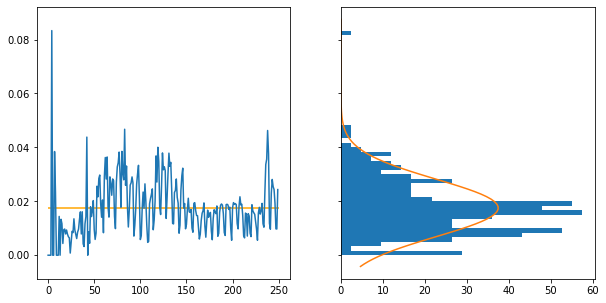

In [6]:
#let's find removal_rate(γ)
removal_rate_arr = d_removed / infected

#fit normal distribution
removal_rate, removal_rate_std = norm.fit(removal_rate_arr)

print("removal_rate (γ) =", round(removal_rate, 3))
print("removal_rate std =", round(removal_rate_std, 3))
print("days in infected (1/γ) =",  round(1/removal_rate, 1))

plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(removal_rate_arr)
ax1.hlines(removal_rate,0,len(removal_rate_arr),color="orange")

ax2.hist(removal_rate_arr, bins=50, density=True, orientation="horizontal")

xmin, xmax = ax2.get_ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, removal_rate, removal_rate_std)
ax2.plot(p, x)

plt.show()

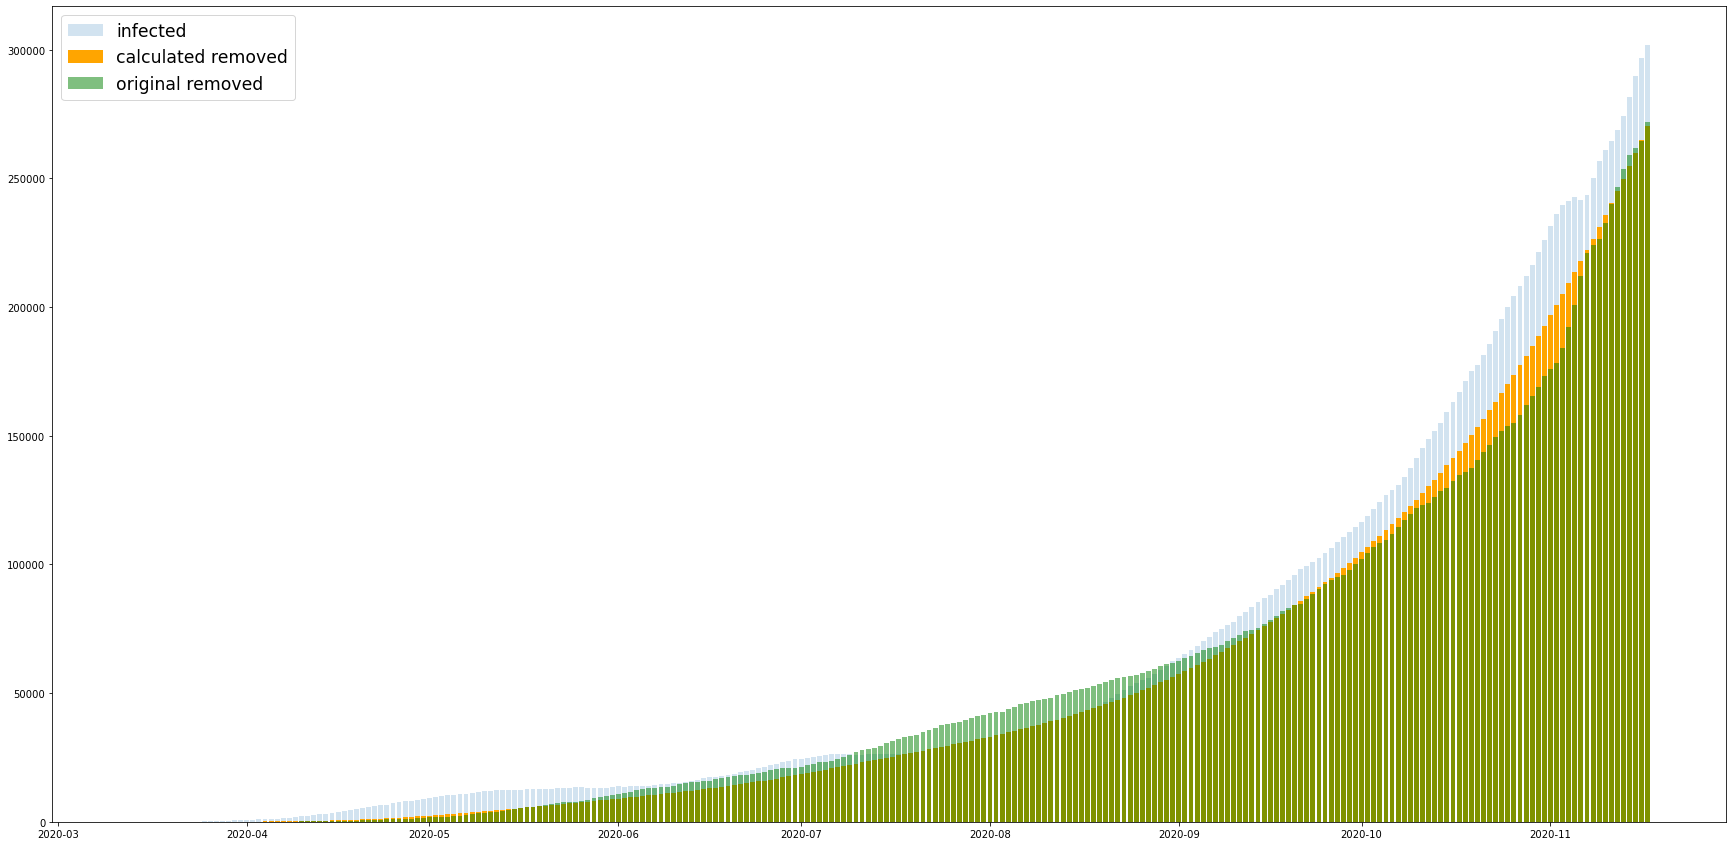

In [7]:
#visual check of calculated vs real removed values

calculated_removed = np.cumsum(removal_rate*infected)

plt.rcParams["figure.figsize"] = [30,15]
fig = plt.figure()

plt.bar(dates, infected, alpha=0.2, label="infected")
plt.bar(dates, calculated_removed, color="orange", label="calculated removed")
plt.bar(dates, removed, color="green", alpha=0.5, label="original removed")
plt.legend(fontsize="xx-large")

plt.show()

infication_rate (β) mu = 0.059
infication_rate_std = 0.08
infication_rate_mode (β) = 0.033


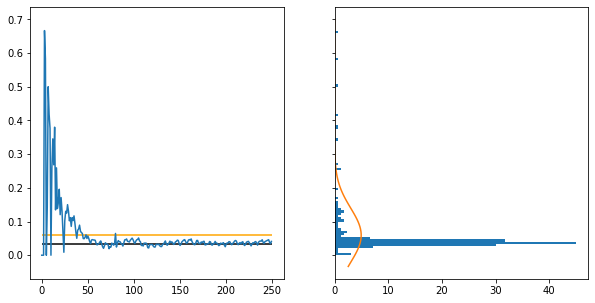

In [8]:
#https://index.minfin.com.ua/ua/reference/people/
#Nation = 41724000 #original minfin value

Nation = 40000000

infication_rate_arr = (Nation * (d_infected + d_removed)) / (infected * (Nation - infected - removed))

infication_rate, infication_rate_std = norm.fit(infication_rate_arr)
print("infication_rate (β) mu =", round(infication_rate, 3))
print("infication_rate_std =", round(infication_rate_std, 3))

plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(infication_rate_arr)
a = ax2.hist(infication_rate_arr, bins=100, density=True, orientation="horizontal")
max_pos = [i for i, j in enumerate(a[0]) if j == max(a[0])][0]
infication_rate_mode = a[1][max_pos]
print("infication_rate_mode (β) =", round(infication_rate_mode, 3))

ax1.hlines(infication_rate_mode, 0, len(infication_rate_arr))
ax1.hlines(infication_rate, 0, len(infication_rate_arr), color="orange")

xmin, xmax = ax2.get_ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, infication_rate, infication_rate_std)
ax2.plot(p, x)

plt.show()

[0.2625068  0.03955029 0.03229231]


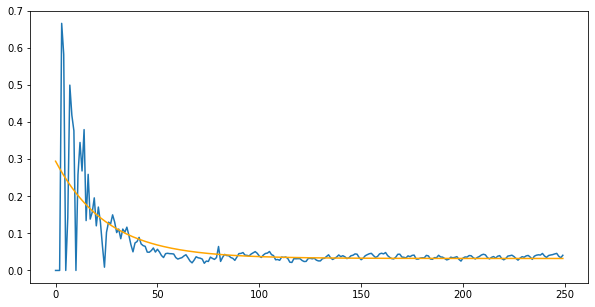

In [9]:
#approximate B as a function of time

def infication_rate_of_time(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.arange(len(infication_rate_arr))

inf_r_opt_coef, pcov = curve_fit(infication_rate_of_time,
                                 x,
                                 infication_rate_arr,
                                 bounds=([0, 0, 0],
                                         [1., 1., infication_rate_mode*3]))
print(inf_r_opt_coef)

inf_r_opt_curve = infication_rate_of_time(x, *inf_r_opt_coef)

plt.rcParams["figure.figsize"] = [10,5]
fig = plt.figure()

plt.plot(infication_rate_arr)
plt.plot(inf_r_opt_curve, color="orange")

plt.show()

In [10]:
# params for fitting, run fitting once!!!
fitting_start_day = 130
fitting_days_to_calculate = len(infected)

print("fitting_start_day =", fitting_start_day)

def calculate_SIR_arrays(start_day, #from this day model fitting starts, starting on early days is very unstable
                         days_to_calculate): #days to calculate from day 0
    
    days = np.arange(days_to_calculate)
    days_slice = days[start_day:]

    if len(days) < start_day:
        raise ValueError("start day must be within days range!")
    
    #reference SIR to check our model
    Ir = [infected[start_day]]
    Sr = [Nation-Ir[0]]
    Rr = [removed[start_day]]

    #calculated SIR based on approximated coefficients
    I = [infected[start_day]]
    S = [Nation-I[0]]
    R = [removed[start_day]]    
    
    for t in days_slice:
        if t<len(removal_rate_arr):
            dr = int(removal_rate_arr[t]*Ir[-1])
            ds = math.ceil((infication_rate_arr[t]) * Sr[-1] * Ir[-1] / Nation)

            Sr.append(Sr[-1] - ds)
            Ir.append(Ir[-1] + ds - dr)
            Rr.append(Rr[-1] + dr)


        dr = int(removal_rate * I[-1])
        ds = math.ceil((infication_rate_of_time(t, *inf_r_opt_coef)) * S[-1] * I[-1] / Nation)

        S.append(S[-1] - ds)
        I.append(I[-1] + ds - dr)
        R.append(R[-1] + dr)
    
    return(S,I,R,Sr,Ir,Rr)

def get_rmse(arr1, arr2, start_day):
    arr1_slice = arr1[start_day:]
    rmse = mean_squared_error(arr1_slice, 
                              arr2[:len(arr1_slice)], 
                              squared=False)
    return(rmse)


###########################
# coefficient fine tuning #
###########################
S,I,R,Sr,Ir,Rr = calculate_SIR_arrays(fitting_start_day, fitting_days_to_calculate)
                         
step = 0.1
rmse_arr = [get_rmse(recovered, R, fitting_start_day)]
iter_counter = 0
max_iterations = 30
rmse_step_thd = 50
while 1:
    #print(inf_r_opt_coef[2])
    removal_rate *= 1 + step
    S,I,R,Sr,Ir,Rr = calculate_SIR_arrays(fitting_start_day, fitting_days_to_calculate)
    rmse_arr.append(get_rmse(recovered, R, fitting_start_day))
    if rmse_arr[-1]<rmse_arr[-2]:
        if abs(rmse_arr[-1]-rmse_arr[-2])<rmse_step_thd:
            print("γ rmse step smaller than thd: {0} < {1}".format(int(abs(rmse_arr[-1]-rmse_arr[-2])), rmse_step_thd))
            break
        step /= 2
        #print("---- removal_rate =", round(removal_rate,4))
    else:
        step *= -1
    iter_counter += 1
    if iter_counter > max_iterations:
        print("reached maximum iterations")
        break
print("γ optimisations steps done =", len(rmse_arr))
print("final γ RMSE =", int(rmse_arr[-1]))
print("final γ value =", round(removal_rate,4))
print()
        
step = 0.1
rmse_arr = [get_rmse(infected, I, fitting_start_day)]
iter_counter = 0
max_iterations = 30
rmse_step_thd = 50
while 1:
    #print(inf_r_opt_coef[2])
    inf_r_opt_coef[2] *= 1 + step
    S,I,R,Sr,Ir,Rr = calculate_SIR_arrays(fitting_start_day, fitting_days_to_calculate)
    rmse_arr.append(get_rmse(infected, I, fitting_start_day))
    if rmse_arr[-1]<rmse_arr[-2]:
        if abs(rmse_arr[-1]-rmse_arr[-2])<rmse_step_thd:
            print("β rmse step smaller than thd: {0} < {1}".format(int(abs(rmse_arr[-1]-rmse_arr[-2])), rmse_step_thd))
            break
        step /= 2
        #print("---- inf_r_opt_coef[2] =", round(inf_r_opt_coef[2],4))
    else:
        step *= -1
    iter_counter += 1
    if iter_counter > max_iterations:
        print("reached maximum iterations")
        break
print("β optimisations steps done =", len(rmse_arr))
print("final β RMSE =", int(rmse_arr[-1]))
print("final β value =", round(inf_r_opt_coef[2],4))

fitting_start_day = 130
γ rmse step smaller than thd: 23 < 50
γ optimisations steps done = 7
final γ RMSE = 19274
final γ value = 0.0158

β rmse step smaller than thd: 46 < 50
β optimisations steps done = 11
final β RMSE = 3870
final β value = 0.0363


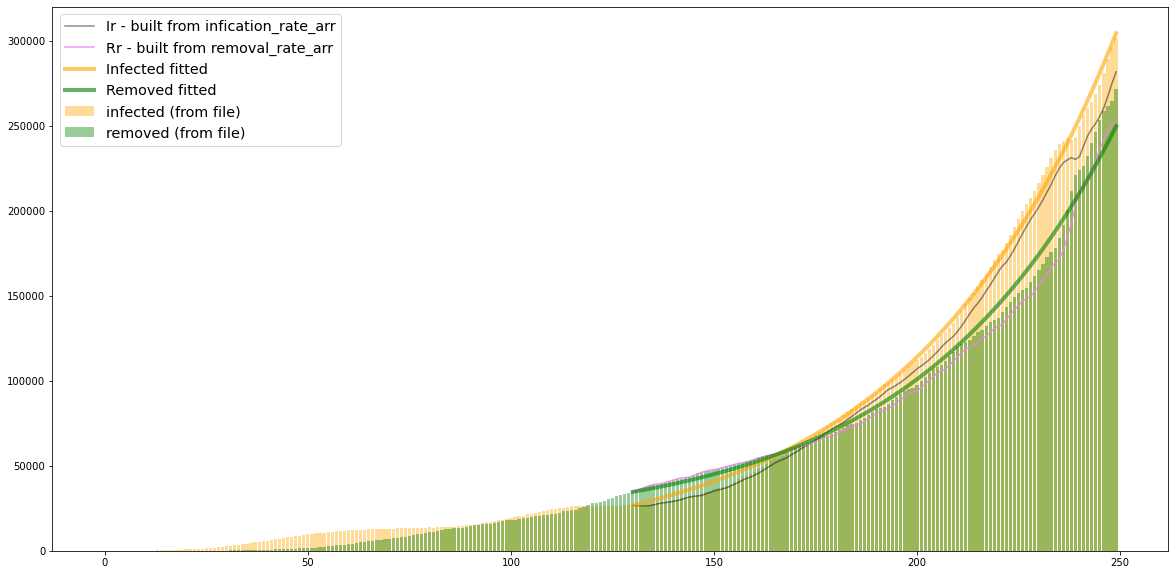

In [11]:
#fitting results visual check
start_day = fitting_start_day
days = np.arange(fitting_days_to_calculate)
days_slice = days[start_day:]

plt.rcParams["figure.figsize"] = [20,10]
fig = plt.figure()

plt.bar(days[:len(infected[:len(days)])], infected[:len(days)], color="orange", alpha=0.4, label="infected (from file)")
plt.bar(days[:len(removed[:len(days)])], removed[:len(days)], color="green", alpha=0.4, label="removed (from file)")

plt.plot(days_slice[:len(Ir)], Ir[:len(days)-start_day], color="black", alpha=0.45,
         label="Ir - built from infication_rate_arr")
plt.plot(days_slice[:len(Rr)], Rr[:len(days)-start_day], color="violet", alpha=0.85,
         label="Rr - built from removal_rate_arr")

#plt.plot(days_slice, S[:-1], color="blue", lw=5., alpha=0.8)
plt.plot(days_slice, I[:-1], color="orange", lw=4., alpha=0.6, label="Infected fitted")
plt.plot(days_slice, R[:-1], color="green", lw=4., alpha=0.6, label="Removed fitted")

plt.legend(fontsize="x-large")

plt.show()

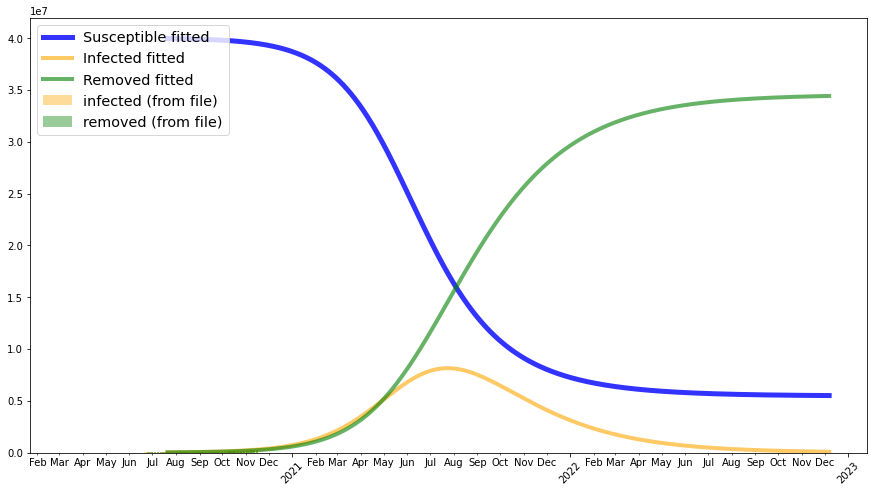

In [12]:
#fullscale SIR model for ~3 years
days = np.arange(1000)
days_slice = days[start_day:]

#dates for plotting
extra_dates = [dates[0] + datetime.timedelta(days=int(i)) for i in days[fitting_start_day:]]

#Nation = 40000000 #original
Nation = 40000000 #debug

S,I,R,Sr,Ir,Rr = calculate_SIR_arrays(fitting_start_day, 1000)

plt.rcParams["figure.figsize"] = [15,8]
fig, ax = plt.subplots()

ax.bar(dates[:len(infected[:len(days)])], infected[:len(days)], color="orange", alpha=0.4, label="infected (from file)")
ax.bar(dates[:len(removed[:len(days)])], removed[:len(days)], color="green", alpha=0.4, label="removed (from file)")

ax.plot(extra_dates, S[:-1], color="blue", lw=5., alpha=0.8, label="Susceptible fitted")
ax.plot(extra_dates, I[:-1], color="orange", lw=4., alpha=0.6, label="Infected fitted")
ax.plot(extra_dates, R[:-1], color="green", lw=4., alpha=0.6, label="Removed fitted")

ax.legend(fontsize="x-large", loc=2)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
month_fmt = mdates.DateFormatter('%b')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(month_fmt)
plt.xticks(rotation=45)

plt.show()

death_rate_average = 0.414%
estimated total deaths (at 2023) = 142680


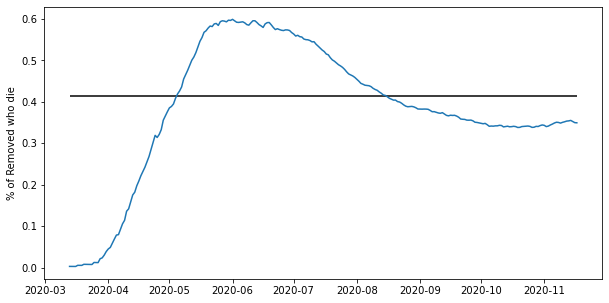

In [13]:
#percent of Removed who die
death_rate = deaths / R[:len(deaths)] * 100

plt.rcParams["figure.figsize"] = [10,5]
fig = plt.figure()

plt.plot(dates, death_rate)
plt.ylabel("% of Removed who die")

death_rate_average = np.average(death_rate[100:])
print("death_rate_average = {0}%".format(round(death_rate_average, 3)))
print("estimated total deaths (at 2023) =", int(R[-1]*death_rate_average/100))
plt.hlines(death_rate_average, dates[0], dates[-1], color="black")

plt.show()

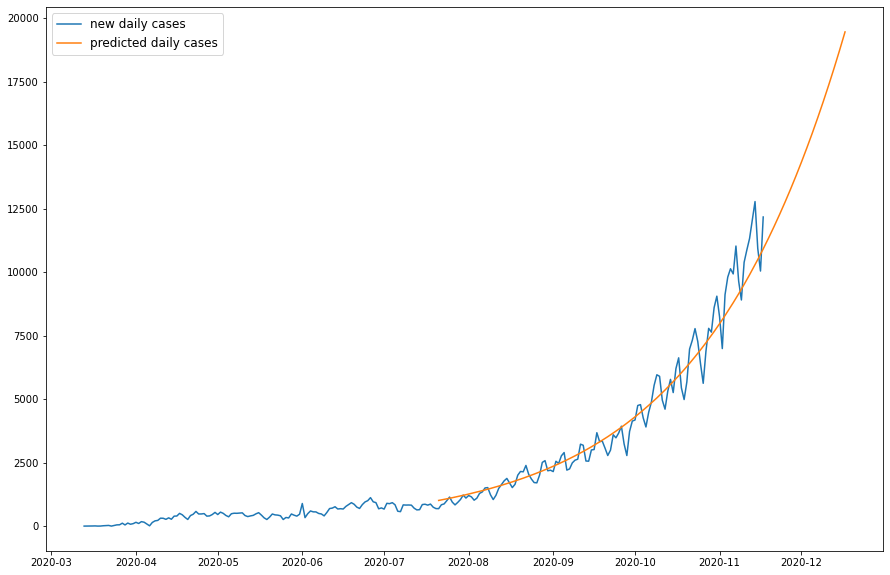

In [14]:
#let's predict some daily cases for nearest future
predicted_daily = np.negative(np.diff(S))

plt.rcParams["figure.figsize"] = [15,10]
fig = plt.figure()

plt.plot(dates, d_confirmed, label="new daily cases")
plt.plot(extra_dates[:150], predicted_daily[:150], label="predicted daily cases")

plt.legend(fontsize="large", loc=2)

plt.show()

In [15]:
#print some nearest daily cases
for date, cases in zip(extra_dates[120:140], predicted_daily[120:140]):
    print(date.strftime("%d-%m-%Y"), " - ", int(cases))

18-11-2020  -  11136
19-11-2020  -  11355
20-11-2020  -  11579
21-11-2020  -  11807
22-11-2020  -  12039
23-11-2020  -  12276
24-11-2020  -  12517
25-11-2020  -  12762
26-11-2020  -  13012
27-11-2020  -  13267
28-11-2020  -  13527
29-11-2020  -  13791
30-11-2020  -  14060
01-12-2020  -  14335
02-12-2020  -  14614
03-12-2020  -  14899
04-12-2020  -  15188
05-12-2020  -  15483
06-12-2020  -  15784
07-12-2020  -  16090
